# Test experimental code on datasets

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
os.chdir('/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental')

In [3]:
from data import DataBuilder
from solver import DualSolver

In [4]:
os.chdir('/Users/ducela/Documents/Raking/ihmeuw-msca/raking/tests')

In [5]:
from conftest import *

In [6]:
os.chdir('/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking')

In [7]:
from run_raking import run_raking

## 1D example

Current version of the code.

In [8]:
example_1D = Example1D()

In [9]:
(df_raked, Dphi_y, Dphi_s, sigma) = run_raking(
    dim=1,
    df_obs=example_1D.df_obs,
    df_margins=[example_1D.df_margin],
    var_names=['var1'],
    method='entropic',
    cov_mat=False)

Check if margins are respected.

In [10]:
np.allclose(df_raked['raked_value'].sum(), example_1D.df_margin['value_agg_over_var1'].iloc[0])

True

Experimental version of the code.

In [11]:
example_1D = Example1D()

In [12]:
df_obs = example_1D.df_obs
df_obs['weights'] = 1.0

In [13]:
df_margin = example_1D.df_margin
df_margin['var1'] = -1
df_margin['weights'] = np.inf
df_margin.rename(columns={'value_agg_over_var1': 'value'}, inplace=True)

In [14]:
df = pd.concat([df_obs, df_margin])

In [15]:
data_builder = DataBuilder(
    dim_specs={'var1': -1},
    value='value',
    weights='weights'
)

In [16]:
data = data_builder.build(df)

In [17]:
solver = DualSolver(distance='entropic', data=data)

In [18]:
df_exp = solver.solve()

In [19]:
solver.result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 6.940801058998988
       x: [-9.961e-04]
     nit: 2
     jac: [-3.448e-06]
    nfev: 3
    njev: 3
    nhev: 2

Check if margins are respected.

In [20]:
np.allclose(df_exp['soln'].sum(), example_1D.df_margin['value'].iloc[0])

True

Create data frame for plotting.

In [21]:
df_raked['version'] = 'current'
df_exp['version'] = 'experimental'

In [22]:
df_exp = df_exp.merge(df, how='inner', on=['var1'])
df_exp = df_exp.drop(columns=['weights']).rename(columns={'soln': 'raked_value'})

In [23]:
df_comp = pd.concat([df_raked, df_exp])

Plot.

In [24]:
min_value = min(df_comp['raked_value'].min(), df_comp['value'].min())
max_value = max(df_comp['raked_value'].max(), df_comp['value'].max())

x1, x2 = alt.param(value=min_value), alt.param(value=max_value)
y1, y2 = alt.param(value=min_value), alt.param(value=max_value)
line = alt.Chart().mark_rule(color='grey').encode(
    x=alt.datum(x1, type='quantitative'),
    x2=alt.datum(x2, type='quantitative'),
    y=alt.datum(y1, type='quantitative'),
    y2=alt.datum(y2, type='quantitative')
).add_params(x1, x2, y1, y2)

mx = alt.Chart().mark_point(size=80, filled=True).encode(
        x=alt.X('value:Q', axis=alt.Axis(title='Observations'), scale=alt.Scale(domain=[x1, x2])),
        y=alt.Y('raked_value:Q', axis=alt.Axis(title='Raked values'), scale=alt.Scale(domain=[y1, y2])),
        color=alt.Color('version:N', legend=alt.Legend(title='Version')),
        shape=alt.Shape('version:N', legend=alt.Legend(title='Version'))
    )
chart = alt.layer(line, mx, data=df_comp).configure_axis(
        labelFontSize=18,
        titleFontSize=18
    ).configure_legend(
        labelFontSize=12,
        titleFontSize=12
    )

In [25]:
chart

alt.LayerChart(...)

Sort values and compare.

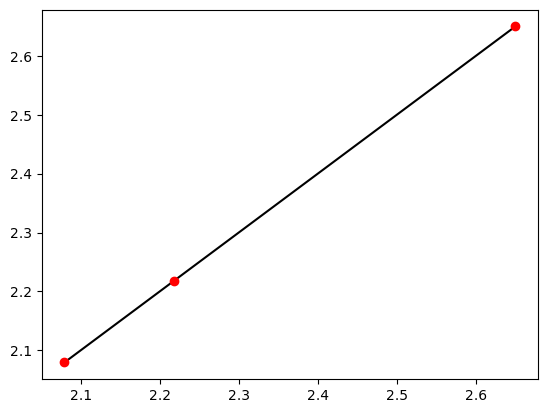

In [26]:
current = df_raked.sort_values(by='var1').raked_value.to_numpy()
experimental = df_exp.sort_values(by='var1').raked_value.to_numpy()
plt.plot(current, current, 'k-')
plt.plot(current, experimental, 'ro')

## 2D example

Current version of the code.

In [27]:
example_2D = Example2D()

In [28]:
(df_raked, Dphi_y, Dphi_s, sigma) = run_raking(
    dim=2,
    df_obs=example_2D.df_obs,
    df_margins=[example_2D.df_margins_1, example_2D.df_margins_2],
    var_names=['var1', 'var2'],
    method='entropic',
    cov_mat=False)

Check if margins are respected.

In [29]:
sum_over_var1 = (
    df_raked.groupby(['var2'])
    .agg({'raked_value': 'sum'})
    .reset_index()
    .merge(example_2D.df_margins_1, on='var2')
)
sum_over_var2 = (
    df_raked.groupby(['var1'])
    .agg({'raked_value': 'sum'})
    .reset_index()
    .merge(example_2D.df_margins_2, on='var1')
)
print(
    np.allclose(
        sum_over_var1['raked_value'], sum_over_var1['value_agg_over_var1']
    ),
    np.allclose(
        sum_over_var2['raked_value'], sum_over_var2['value_agg_over_var2']
    ),
)

True True


Experimental version of the code.

In [30]:
example_2D = Example2D()

In [31]:
df_obs = example_2D.df_obs
df_obs['weights'] = 1.0

In [32]:
df_margins_1 = example_2D.df_margins_1
df_margins_1['var1'] = -1
df_margins_1['weights'] = np.inf
df_margins_1.rename(columns={'value_agg_over_var1': 'value'}, inplace=True)

In [33]:
df_margins_2 = example_2D.df_margins_2
df_margins_2['var2'] = -1
df_margins_2['weights'] = np.inf
df_margins_2.rename(columns={'value_agg_over_var2': 'value'}, inplace=True)

In [34]:
df = pd.concat([df_obs, df_margins_1, df_margins_2])

In [35]:
data_builder = DataBuilder(
    dim_specs={'var1': -1, 'var2': -1},
    value='value',
    weights='weights'
)

In [36]:
data = data_builder.build(df)

In [37]:
solver = DualSolver(distance='entropic', data=data)

In [38]:
df_exp = solver.solve()

In [39]:
solver.result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 37.927277836336025
       x: [-4.717e-03 -1.792e-02 -1.830e-02 -5.281e-03  3.278e-02
            2.807e-02  1.769e-02]
     nit: 5
     jac: [-1.368e-07 -1.837e-08  2.653e-07 -4.103e-07  1.124e-06
           -6.452e-07  1.265e-08]
    nfev: 6
    njev: 6
    nhev: 5

In [40]:
sum_over_var1 = (
    df_exp.groupby(['var2'])
    .agg({'soln': 'sum'})
    .reset_index()
    .merge(example_2D.df_margins_1, on='var2')
)

Check if margins are respected.

In [41]:
sum_over_var1 = (
    df_exp.groupby(['var2'])
    .agg({'soln': 'sum'})
    .reset_index()
    .merge(example_2D.df_margins_1, on='var2')
)
sum_over_var2 = (
    df_exp.groupby(['var1'])
    .agg({'soln': 'sum'})
    .reset_index()
    .merge(example_2D.df_margins_2, on='var1')
)
print(
    np.allclose(
        sum_over_var1['soln'], sum_over_var1['value']
    ),
    np.allclose(
        sum_over_var2['soln'], sum_over_var2['value']
    ),
)

True True


Create data frame for plotting.

In [42]:
df_raked['version'] = 'current'
df_exp['version'] = 'experimental'

In [43]:
df_exp = df_exp.merge(df, how='inner', on=['var1', 'var2'])
df_exp = df_exp.drop(columns=['weights']).rename(columns={'soln': 'raked_value'})

In [44]:
df_comp = pd.concat([df_raked, df_exp])

Plot.

In [45]:
min_value = min(df_comp['raked_value'].min(), df_comp['value'].min())
max_value = max(df_comp['raked_value'].max(), df_comp['value'].max())

x1, x2 = alt.param(value=min_value), alt.param(value=max_value)
y1, y2 = alt.param(value=min_value), alt.param(value=max_value)
line = alt.Chart().mark_rule(color='grey').encode(
    x=alt.datum(x1, type='quantitative'),
    x2=alt.datum(x2, type='quantitative'),
    y=alt.datum(y1, type='quantitative'),
    y2=alt.datum(y2, type='quantitative')
).add_params(x1, x2, y1, y2)

mx = alt.Chart().mark_point(size=80, filled=True).encode(
        x=alt.X('value:Q', axis=alt.Axis(title='Observations'), scale=alt.Scale(domain=[x1, x2])),
        y=alt.Y('raked_value:Q', axis=alt.Axis(title='Raked values'), scale=alt.Scale(domain=[y1, y2])),
        color=alt.Color('version:N', legend=alt.Legend(title='Version')),
        shape=alt.Shape('version:N', legend=alt.Legend(title='Version'))
    )
chart = alt.layer(line, mx, data=df_comp).configure_axis(
        labelFontSize=18,
        titleFontSize=18
    ).configure_legend(
        labelFontSize=12,
        titleFontSize=12
    )

In [46]:
chart

alt.LayerChart(...)

Sort values and compare.

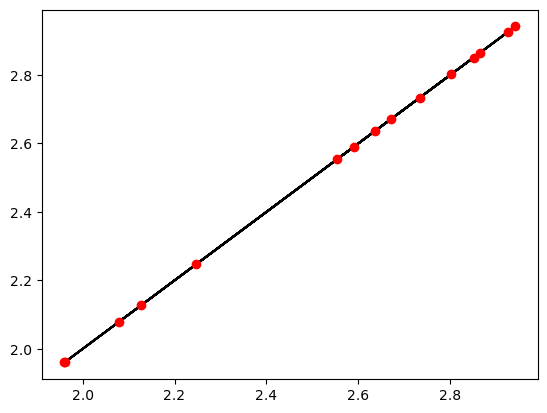

In [47]:
current = df_raked.sort_values(by=['var1', 'var2']).raked_value.to_numpy()
experimental = df_exp.sort_values(by=['var1', 'var2']).raked_value.to_numpy()
plt.plot(current, current, 'k-')
plt.plot(current, experimental, 'ro')

## 3D example

Current version of the code.

In [48]:
example_3D = Example3D()

In [49]:
(df_raked, Dphi_y, Dphi_s, sigma) = run_raking(
    dim=3,
    df_obs=example_3D.df_obs,
    df_margins=[example_3D.df_margins_1, example_3D.df_margins_2, example_3D.df_margins_3],
    var_names=['var1', 'var2', 'var3'],
    method='entropic',
    cov_mat=False)

Check if margins are respected.

In [50]:
sum_over_var1 = (
    df_raked.groupby(["var2", "var3"])
    .agg({"raked_value": "sum"})
    .reset_index()
    .merge(example_3D.df_margins_1, on=["var2", "var3"])
)
sum_over_var2 = (
    df_raked.groupby(["var1", "var3"])
    .agg({"raked_value": "sum"})
    .reset_index()
    .merge(example_3D.df_margins_2, on=["var1", "var3"])
)
sum_over_var3 = (
    df_raked.groupby(["var1", "var2"])
    .agg({"raked_value": "sum"})
    .reset_index()
    .merge(example_3D.df_margins_3, on=["var1", "var2"])
)
print(
    np.allclose(
        sum_over_var1["raked_value"], sum_over_var1["value_agg_over_var1"]
    ),
    np.allclose(
        sum_over_var2["raked_value"], sum_over_var2["value_agg_over_var2"]
    ),
    np.allclose(
        sum_over_var3["raked_value"], sum_over_var3["value_agg_over_var3"]
    ),
)

True True True


Experimental version of the code.

In [51]:
example_3D = Example3D()

In [52]:
df_obs = example_3D.df_obs
df_obs['weights'] = 1.0

In [53]:
df_margins_1 = example_3D.df_margins_1
df_margins_1['var1'] = -1
df_margins_1['weights'] = np.inf
df_margins_1.rename(columns={'value_agg_over_var1': 'value'}, inplace=True)

In [54]:
df_margins_2 = example_3D.df_margins_2
df_margins_2['var2'] = -1
df_margins_2['weights'] = np.inf
df_margins_2.rename(columns={'value_agg_over_var2': 'value'}, inplace=True)

In [55]:
df_margins_3 = example_3D.df_margins_3
df_margins_3['var3'] = -1
df_margins_3['weights'] = np.inf
df_margins_3.rename(columns={'value_agg_over_var3': 'value'}, inplace=True)

In [56]:
df = pd.concat([df_obs, df_margins_1, df_margins_2, df_margins_3])

In [57]:
data_builder = DataBuilder(
    dim_specs={'var1': -1, 'var2': -1, 'var3': -1},
    value='value',
    weights='weights'
)

In [58]:
#data = data_builder.build(df)

## USHD example

Current version of the code.

In [59]:
example_USHD = ExampleUSHD()

In [60]:
(df_raked, Dphi_y, Dphi_s, sigma) = run_raking(
    dim='USHD',
    df_obs=example_USHD.df_obs,
    df_margins=[example_USHD.df_margins],
    var_names=None,
    method='entropic',
    cov_mat=False)

Check if margins are respected.

In [61]:
sum_over_race_county = (
    df_raked.loc[df_raked.race != 0].groupby(['cause'])
    .agg({'raked_value': 'sum'})
    .reset_index()
    .merge(example_USHD.df_margins, on=['cause'])
    )
np.allclose(
    sum_over_race_county['raked_value'],
    sum_over_race_county['value_agg_over_race_county'],
    atol=1.0e-5,
)

True

Rename values for merging with experimental results.

In [62]:
df_raked.replace({'cause': '_all', 'race': 0}, -1, inplace=True)
df_raked.drop(columns=['upper'], inplace=True)
df_raked.replace({'cause': {'_comm': 1, '_inj': 2, '_ncd': 3}}, inplace=True)

Experimental version of the code.

In [63]:
example_USHD = ExampleUSHD()

In [64]:
df_obs = example_USHD.df_obs
df_obs['weights'] = 1.0
df_obs.replace({'cause': '_all', 'race': 0}, -1, inplace=True)
df_obs.drop(columns=['upper'], inplace=True)
df_obs.replace({'cause': {'_comm': 1, '_inj': 2, '_ncd': 3}}, inplace=True)

In [65]:
df_margin = example_USHD.df_margins
df_margin['race'] = -1
df_margin['county'] = -1
df_margin['weights'] = np.inf
df_margin.rename(columns={'value_agg_over_race_county': 'value'}, inplace=True)
df_margin.replace({'cause': {'_all': -1, '_comm': 1, '_inj': 2, '_ncd': 3}}, inplace=True)

In [66]:
df = pd.concat([df_obs, df_margin])

In [67]:
df = df.astype({'cause': 'int64'})

In [68]:
data_builder = DataBuilder(
    dim_specs={'cause': -1, 'race': -1, 'county': -1},
    value='value',
    weights='weights'
)

In [69]:
data = data_builder.build(df)

/Users/ducela/Documents/Raking/ihmeuw-msca/raking/src/raking/experimental/data.py:230: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_i_to_j = pd.concat(


In [70]:
solver = DualSolver(distance='entropic', data=data)

In [71]:
df_exp = solver.solve()

In [72]:
solver.result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -574.3099097037687
       x: [ 7.732e+00  2.574e+00 ... -5.760e+00 -1.281e+01]
     nit: 17
     jac: [ 1.057e-07  4.401e-06 ... -1.427e-06 -1.540e-06]
    nfev: 22
    njev: 22
    nhev: 17

Check if margins are respected.

In [73]:
sum_over_race_county = (
    df_exp.groupby(['cause'])
    .agg({'soln': 'sum'})
    .reset_index()
    .merge(df_margin, on=['cause'])
    )
np.allclose(
    sum_over_race_county['soln'],
    sum_over_race_county['value'],
    atol=1.0e-5,
)

True

Add partial sums to dataset.

In [74]:
sum_over_cause = (
    df_exp.groupby(['race', 'county'])
    .agg({'soln': 'sum'})
    .reset_index()
)
sum_over_cause['cause'] = -1

In [75]:
sum_over_race = (
    df_exp.groupby(['cause', 'county'])
    .agg({'soln': 'sum'})
    .reset_index()
)
sum_over_race['race'] = -1

In [76]:
sum_over_cause_race = (
    df_exp.groupby(['county'])
    .agg({'soln': 'sum'})
    .reset_index()
)
sum_over_cause_race['cause'] = -1
sum_over_cause_race['race'] = -1

In [77]:
df_exp = pd.concat([df_exp, sum_over_cause, sum_over_race, sum_over_cause_race])

Create data frame for plotting.

In [78]:
df_raked['version'] = 'current'
df_exp['version'] = 'experimental'

In [79]:
df_exp = df_exp.merge(df, how='inner', on=['cause', 'race', 'county'])
df_exp = df_exp.drop(columns=['weights']).rename(columns={'soln': 'raked_value'})

In [80]:
df_comp = pd.concat([df_raked, df_exp])

Plot.

In [81]:
min_value = min(df_comp['raked_value'].min(), df_comp['value'].min())
max_value = max(df_comp['raked_value'].max(), df_comp['value'].max())

x1, x2 = alt.param(value=min_value), alt.param(value=max_value)
y1, y2 = alt.param(value=min_value), alt.param(value=max_value)
line = alt.Chart().mark_rule(color='grey').encode(
    x=alt.datum(x1, type='quantitative'),
    x2=alt.datum(x2, type='quantitative'),
    y=alt.datum(y1, type='quantitative'),
    y2=alt.datum(y2, type='quantitative')
).add_params(x1, x2, y1, y2)

mx = alt.Chart().mark_point(size=80, filled=True).encode(
        x=alt.X('value:Q', axis=alt.Axis(title='Observations'), scale=alt.Scale(domain=[x1, x2])),
        y=alt.Y('raked_value:Q', axis=alt.Axis(title='Raked values'), scale=alt.Scale(domain=[y1, y2])),
        color=alt.Color('version:N', legend=alt.Legend(title='Version')),
        shape=alt.Shape('version:N', legend=alt.Legend(title='Version'))
    )
chart = alt.layer(line, mx, data=df_comp).configure_axis(
        labelFontSize=18,
        titleFontSize=18
    ).configure_legend(
        labelFontSize=12,
        titleFontSize=12
    )

In [82]:
chart

alt.LayerChart(...)

In [83]:
#chart.save("comparison.png")

Sort values and compare.

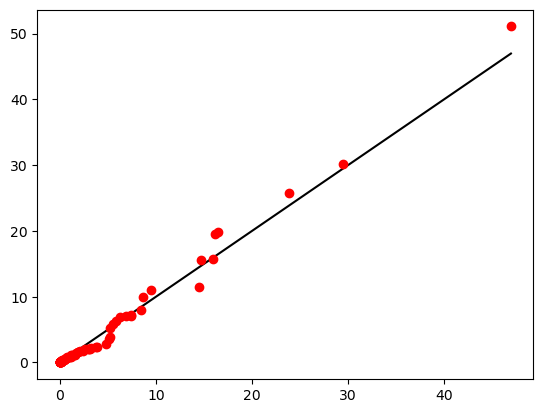

In [84]:
current = df_raked.raked_value.to_numpy()
current.sort()
experimental = df_exp.raked_value.to_numpy()
experimental.sort()
plt.plot(current, current, 'k-')
plt.plot(current, experimental, 'ro')